# **Prediction in Flight Delays using Random Forest Algorithm**

**importing libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/flight-delays/airports.csv
/kaggle/input/flight-delays/airlines.csv
/kaggle/input/flight-delays/flights.csv


In [3]:
low_memory=False

In [4]:
df = pd.read_csv('/kaggle/input/flight-delays/flights.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.shape

(5819079, 31)

In [6]:
df.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

In [7]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


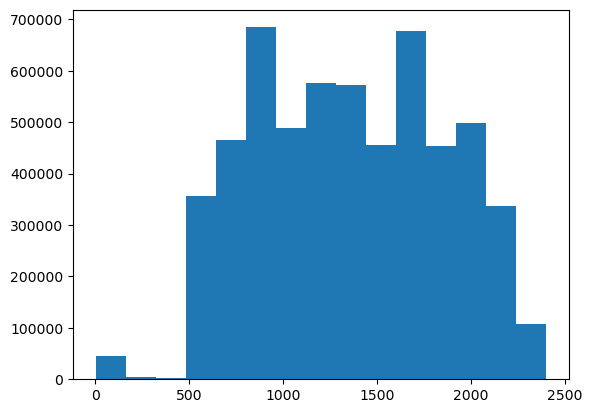

In [8]:
import matplotlib.pyplot as plt
plt.hist(df['WHEELS_OFF'], bins=15)
plt.show()

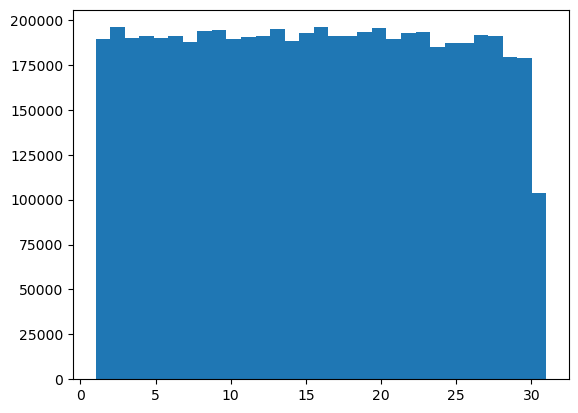

In [9]:
import matplotlib.pyplot as plt
plt.hist(df['DAY'], bins=31)
plt.show()

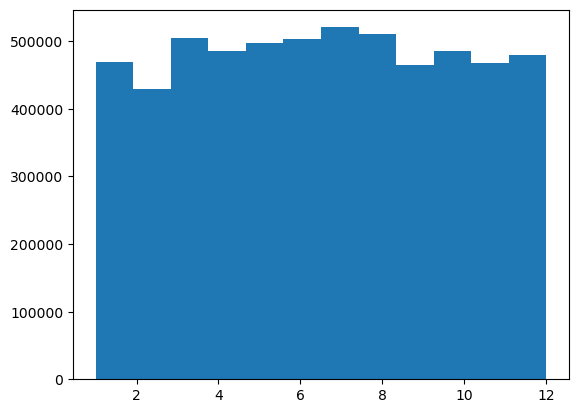

In [10]:
import matplotlib.pyplot as plt
plt.hist(df['MONTH'], bins=12)
plt.show()

**Cleaning** Unnecessary Columns for the Delay Calculation

In [11]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [12]:
df.drop(['ARRIVAL_TIME',  'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY','DEPARTURE_TIME','WHEELS_ON', 'TAXI_IN',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
         'ELAPSED_TIME', 'AIR_TIME',],axis = 1,inplace = True)

In [13]:
df.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_TIME         float64
DISTANCE                 int64
SCHEDULED_ARRIVAL        int64
ARRIVAL_DELAY          float64
dtype: object

In [14]:
df['AIRLINE'].value_counts()

WN    1261855
DL     875881
AA     725984
OO     588353
EV     571977
UA     515723
MQ     294632
B6     267048
US     198715
AS     172521
NK     117379
F9      90836
HA      76272
VX      61903
Name: AIRLINE, dtype: int64

In [15]:
df['ORIGIN_AIRPORT'].value_counts()

ATL      346836
ORD      285884
DFW      239551
DEN      196055
LAX      194673
          ...  
11503         1
14222         1
13964         1
13459         1
12265         1
Name: ORIGIN_AIRPORT, Length: 930, dtype: int64

**We see there are some airports, only flew 1 times. So we can filter out the airports with less than 50 flights.**

In [17]:
#x = df.groupby('DESTINATION_AIRPORT').count()
#y = x[x.iloc[:,0]<50].index
#y

**We found a better approach, the iata codes of airports are already in airports.csv file, so we filter out the flights to elsewhere than the airports in the airports.csv list.**

In [18]:
airports = pd.read_csv('/kaggle/input/flight-delays/airports.csv')
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [19]:
df = df[df['ORIGIN_AIRPORT'].isin(airports['IATA_CODE'])]
df = df[df['DESTINATION_AIRPORT'].isin(airports['IATA_CODE'])]
df.shape

(5332914, 14)

**Airlines in a single column -> One Hot Encoding -> Multiple Columns**

In [20]:
pd.get_dummies(df['AIRLINE'])

,AA,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5819075,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5819076,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5819077,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df = pd.concat([df, pd.get_dummies(df['AIRLINE'])],axis = 1)
df.drop('AIRLINE',axis = 1,inplace = True)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,...,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,2015,1,1,4,98,N407AS,ANC,SEA,5,205.0,...,0,0,0,0,0,0,0,0,0,0
1,2015,1,1,4,2336,N3KUAA,LAX,PBI,10,280.0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,4,840,N171US,SFO,CLT,20,286.0,...,0,0,0,0,0,0,0,1,0,0
3,2015,1,1,4,258,N3HYAA,LAX,MIA,20,285.0,...,0,0,0,0,0,0,0,0,0,0
4,2015,1,1,4,135,N527AS,SEA,ANC,25,235.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df.drop('FLIGHT_NUMBER',axis = 1, inplace = True)

In [23]:
df.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_TIME         float64
DISTANCE                 int64
SCHEDULED_ARRIVAL        int64
ARRIVAL_DELAY          float64
AA                       uint8
AS                       uint8
B6                       uint8
DL                       uint8
EV                       uint8
F9                       uint8
HA                       uint8
MQ                       uint8
NK                       uint8
OO                       uint8
UA                       uint8
US                       uint8
VX                       uint8
WN                       uint8
dtype: object

# **Calculating Ground Time** : 
Ground Time is the time before each flight and if the ground time longer, the expected delay will be less (because the staff will have more time for routines). 
Ground Time = (Scheduled Departure time) - (Scheduled Arrival time of previous flight)

So, how can we find the scheduled arrival time of previous flight?
Solution: 
1. Sort flights for each tail number.
2. Add (previous flight arrival time) to the next flight 
3. Subtract two values : (Scheduled Departure time) - (Scheduled Arrival time of previous flight)


In [24]:
df['TAIL_NUMBER'].value_counts()

N480HA    3446
N488HA    3390
N484HA    3343
N493HA    3295
N478HA    3237
          ... 
N860NW       1
N7LBAA       1
N7LEAA       1
N826MH       1
N175UA       1
Name: TAIL_NUMBER, Length: 4896, dtype: int64

Now, we discover some planes (tail_numbers) have less than 50 flights (even 1 flight), so we filter them out.

In [25]:
x = df.groupby('TAIL_NUMBER').count()
y = x[x.iloc[:,0]<50].index
y

Index(['D942DN', 'N104UA', 'N107UA', 'N116UA', 'N117UA', 'N118UA', 'N119UA',
       'N1200K', 'N1201P', 'N120UA',
       ...
       'N8676A', 'N867DA', 'N885AA', 'N8AHAA', 'N8AJAA', 'N8AKAA', 'N8ALAA',
       'N8AMAA', 'N8ANAA', 'N959JB'],
      dtype='object', name='TAIL_NUMBER', length=321)

In [26]:
df = df[~df['TAIL_NUMBER'].isin(y)]
df.shape

(5327181, 26)

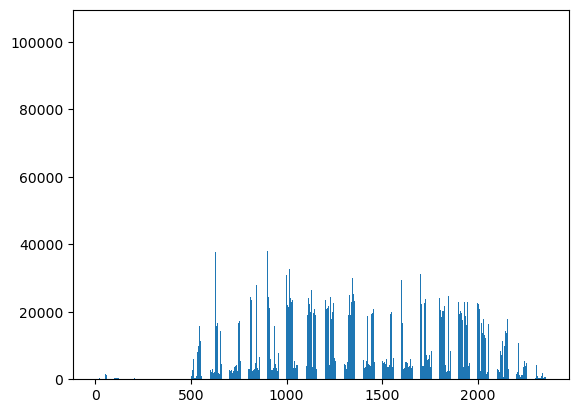

In [27]:
import matplotlib.pyplot as plt
plt.hist(df['SCHEDULED_DEPARTURE'], bins=1000)
plt.show()

We understand that, the scheduled_time column keeps time of departure in numeric format, for example 3:40 is converted to 340. Now we transform it to minutes from 00:00

In [ ]:
df['SCHEDULED_DEPARTURE']=round(df['SCHEDULED_DEPARTURE']/100,0)*60 + df['SCHEDULED_DEPARTURE']%100
df['SCHEDULED_ARRIVAL']=round(df['SCHEDULED_ARRIVAL']/100,0)*60 + df['SCHEDULED_ARRIVAL']%100
plt.hist(df['SCHEDULED_DEPARTURE'], bins=1000)
plt.show()

now the values are between 0 to 1440 (24.00) and we can subtract them from each other

# Calculating the Ground Time and Delay from Previous Flight

We believe if there is a delay from the previous flight and there is a tiny ground time, the delay for this flight is inevitable. 

In [28]:
df= df.sample(frac=0.01, replace=True, random_state=1)

In [29]:
df.shape

(53272, 26)

In [30]:
result = pd.DataFrame(columns =['Previous_Arrival', 'Previous_Delay']  + list(df.columns)  )
for air_plane in df['TAIL_NUMBER'].unique():
    temp = df[df['TAIL_NUMBER']==air_plane]
    temp = temp.sort_values(['YEAR','MONTH','DAY','SCHEDULED_DEPARTURE'])
    temp['Previous_Arrival'] = temp['SCHEDULED_ARRIVAL'].shift(1)
    temp['Previous_Delay'] = temp['ARRIVAL_DELAY'].shift(1)
    result = pd.concat([result,temp])
result.head()


,Previous_Arrival,Previous_Delay,YEAR,MONTH,DAY,DAY_OF_WEEK,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
696674,NaN,NaN,2015,2,16,1,N14902,GPT,IAH,635,...,1,0,0,0,0,0,0,0,0,0
1198034,805.0,-10.0,2015,3,19,4,N14902,TUL,IAH,1150,...,1,0,0,0,0,0,0,0,0,0
2754221,1328.0,-13.0,2015,6,22,1,N14902,DCA,EWR,2135,...,1,0,0,0,0,0,0,0,0,0
3752749,2245.0,111.0,2015,8,21,5,N14902,IAH,TUL,1257,...,1,0,0,0,0,0,0,0,0,0
4326495,1432.0,-6.0,2015,9,27,7,N14902,BNA,EWR,1105,...,1,0,0,0,0,0,0,0,0,0


In [31]:
def f(x):
    if(x<0):
        return 1440 + x
    return x

result['Ground_Time'] = result['SCHEDULED_DEPARTURE'] - result['Previous_Arrival']
result['Ground_Time'] = result['Ground_Time'].apply(f)
df = result
df.head()

,Previous_Arrival,Previous_Delay,YEAR,MONTH,DAY,DAY_OF_WEEK,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,F9,HA,MQ,NK,OO,UA,US,VX,WN,Ground_Time
696674,NaN,NaN,2015,2,16,1,N14902,GPT,IAH,635,...,0,0,0,0,0,0,0,0,0,NaN
1198034,805.0,-10.0,2015,3,19,4,N14902,TUL,IAH,1150,...,0,0,0,0,0,0,0,0,0,345.0
2754221,1328.0,-13.0,2015,6,22,1,N14902,DCA,EWR,2135,...,0,0,0,0,0,0,0,0,0,807.0
3752749,2245.0,111.0,2015,8,21,5,N14902,IAH,TUL,1257,...,0,0,0,0,0,0,0,0,0,452.0
4326495,1432.0,-6.0,2015,9,27,7,N14902,BNA,EWR,1105,...,0,0,0,0,0,0,0,0,0,1113.0


In [33]:

df.drop(['TAIL_NUMBER'],axis = 1,inplace = True)

KeyError: "['TAIL_NUMBER'] not found in axis"

In [34]:
df['Route'] = df['ORIGIN_AIRPORT'] + df['DESTINATION_AIRPORT']
df.drop(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'],axis = 1,inplace = True)

In [35]:
df.head()

,Previous_Arrival,Previous_Delay,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,...,HA,MQ,NK,OO,UA,US,VX,WN,Ground_Time,Route
696674,NaN,NaN,2015,2,16,1,635,90.0,376,805,...,0,0,0,0,0,0,0,0,NaN,GPTIAH
1198034,805.0,-10.0,2015,3,19,4,1150,98.0,429,1328,...,0,0,0,0,0,0,0,0,345.0,TULIAH
2754221,1328.0,-13.0,2015,6,22,1,2135,70.0,199,2245,...,0,0,0,0,0,0,0,0,807.0,DCAEWR
3752749,2245.0,111.0,2015,8,21,5,1257,95.0,429,1432,...,0,0,0,0,0,0,0,0,452.0,IAHTUL
4326495,1432.0,-6.0,2015,9,27,7,1105,134.0,748,1419,...,0,0,0,0,0,0,0,0,1113.0,BNAEWR


In [36]:
len(df['Route'].unique())

4120

In [38]:
# Route should be a part of training data , most probably with one hot encoding
# because of memory limit we drop the column
df.drop('Route',axis = 1,inplace = True)

KeyError: "['Route'] not found in axis"

# Missing Data
For simplicity we replace the missing data with 0 
- ARRIVAL_DELAY = 0 , means no delay
- Previous_Delay = 0, no previous delay
- Ground_Time = 0 , no ground time before flight (usually for the first flight of the tail_number)

In [39]:
df = df.fillna(0)

# Machine Learning -> Modeling Phase
First, we create the input and target data sets , X and y
than create the training and test sets with train_test_split from sklearn

In [40]:
df.corr()

,Previous_Arrival,Previous_Delay,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,...,F9,HA,MQ,NK,OO,UA,US,VX,WN,Ground_Time
Previous_Arrival,1.000000,0.086645,NaN,0.236671,0.061001,-0.004953,0.005553,-0.031379,-0.030336,-0.004897,...,-0.003662,-0.009213,-0.004514,0.000427,0.004525,-0.035853,-0.030851,0.009837,0.020392,0.104963
Previous_Delay,0.086645,1.000000,NaN,-0.026544,0.005753,0.007303,0.003351,-0.007690,-0.006654,0.004944,...,0.025709,-0.004737,0.020904,0.036484,0.007920,0.011606,0.001863,-0.000812,0.000447,0.000861
YEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONTH,0.236671,-0.026544,NaN,1.000000,0.005312,-0.016768,0.003930,0.016890,0.015532,-0.010338,...,0.010170,-0.001233,-0.024694,0.008791,-0.005743,0.005675,-0.149975,0.006254,0.003926,0.156343
DAY,0.061001,0.005753,NaN,0.005312,1.000000,0.001971,-0.001504,-0.003250,-0.001696,-0.003621,...,0.004672,-0.000713,-0.000570,0.002061,-0.000530,0.003076,-0.005630,0.002945,-0.004391,0.034187
DAY_OF_WEEK,-0.004953,0.007303,NaN,-0.016768,0.001971,1.000000,0.011026,0.009999,0.011213,0.008715,...,-0.007165,0.001859,-0.003439,0.002313,0.005630,-0.005181,0.011734,-0.003824,-0.006124,0.004694
SCHEDULED_DEPARTURE,0.005553,0.003351,NaN,0.003930,-0.001504,0.011026,1.000000,-0.010924,-0.004228,0.706132,...,0.005827,-0.011089,-0.007125,0.011281,0.003579,-0.007746,0.006096,0.012919,-0.002834,0.172927
SCHEDULED_TIME,-0.031379,-0.007690,NaN,0.016890,-0.003250,0.009999,-0.010924,1.000000,0.984169,0.037756,...,0.028529,-0.050947,-0.142995,0.031905,-0.173297,0.247928,0.025665,0.098024,-0.098731,-0.031924
DISTANCE,-0.030336,-0.006654,NaN,0.015532,-0.001696,0.011213,-0.004228,0.984169,1.000000,0.032245,...,0.035346,-0.023751,-0.154953,0.039535,-0.179066,0.238153,0.022706,0.101168,-0.069822,-0.030330
SCHEDULED_ARRIVAL,-0.004897,0.004944,NaN,-0.010338,-0.003621,0.008715,0.706132,0.037756,0.032245,1.000000,...,-0.009911,-0.018026,-0.015139,-0.004395,-0.006849,-0.008571,0.006093,0.018593,-0.010366,0.112905


In [42]:
X = df.drop('ARRIVAL_DELAY',axis = 1)
y = df['ARRIVAL_DELAY']


****

**We convert the problem to "delay" or "no delay" classes. 


**Assumption** : 
- if the delay is greater than 15 minutes we accept it as a delay = 1 , 
- if there is no delay or less than 15 minutes than delay = 0**

In [43]:
y = y> 15
y = y.replace({True:1,False:0})
y

696674     0
1198034    0
2754221    1
3752749    0
4326495    1
          ..
2700586    0
1637982    0
3315740    0
1096802    0
2124582    1
Name: ARRIVAL_DELAY, Length: 53130, dtype: int64

In [44]:
y.value_counts()

0    43741
1     9389
Name: ARRIVAL_DELAY, dtype: int64

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train.head()

,Previous_Arrival,Previous_Delay,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,...,F9,HA,MQ,NK,OO,UA,US,VX,WN,Ground_Time
5572422,855.0,-7.0,2015,12,16,3,715,190.0,1079,1025,...,0,0,0,0,0,0,0,0,1,1300.0
5673914,1838.0,-5.0,2015,12,22,2,1230,81.0,353,1351,...,0,0,0,0,1,0,0,0,0,832.0
371409,0.0,0.0,2015,1,25,7,1327,94.0,546,1601,...,0,0,0,0,0,0,0,0,0,0.0
5655405,1508.0,-8.0,2015,12,21,1,1015,52.0,108,1107,...,0,0,1,0,0,0,0,0,0,947.0
844984,1138.0,-18.0,2015,2,25,3,1304,205.0,1416,1729,...,0,0,0,0,0,1,0,0,0,166.0


First attempt is trying random forest algorithm

In [46]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred)
acc

0.8208521074545143

In [47]:
rfc.feature_importances_

array([0.0988025 , 0.09179889, 0.        , 0.05649851, 0.08660199,
       0.05211197, 0.11569362, 0.09978522, 0.10581598, 0.11631368,
       0.00825927, 0.00351119, 0.00551017, 0.00594041, 0.00729682,
       0.00374828, 0.00133637, 0.00622929, 0.00421309, 0.00753383,
       0.00725277, 0.00464083, 0.00244084, 0.00926993, 0.09939455])

In [48]:
X.columns

Index(['Previous_Arrival', 'Previous_Delay', 'YEAR', 'MONTH', 'DAY',
       'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ',
       'NK', 'OO', 'UA', 'US', 'VX', 'WN', 'Ground_Time'],
      dtype='object')